# Wisconsin Breast Cancer Prediction/Classification
Approximate run time: 420 seconds (7 minutes).

## Objective:
To develop a model that can predict whether a given observation (from the Wisconsin Breast Cancer dataset) is malignant or not.

**Note:** It is more important for a model to be able to accurately identify a malignant observation as being malignant than it is for it to be able to accuratley identify a benign observations as being benign - misidentify a malignant observation as benign could cost someone their life!

## Imports

In [1]:
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')


from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier, HistGradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score

## Wisconsin Breast Cancer (WBC) Dataset Description

The WBC dataset (created by Dr. William H. Wolberg, W. Nick Street, Olvi L. Mangasarian - published November 1995) contains 569 observations across 30 features. The features were computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image.

The mean, standard error, and "worst" or largest (mean of the three worst/largest values) of 10 different attributes were computed for each image, resulting in 30 features. For instance, field 0 is Mean Radius, field 10 is Radius SE, field 20 is Worst Radius.

Attribute Information:
- radius (mean of distances from center to points on the perimeter)
- texture (standard deviation of gray-scale values)
- perimeter
- area
- smoothness (local variation in radius lengths)
- compactness (perimeter^2 / area - 1.0)
- concavity (severity of concave portions of the contour)
- concave points (number of concave portions of the contour)
- symmetry
- fractal dimension ("coastline approximation" - 1)

Every observation is classed as being either malignant or benign, with a total of 212 malignant observations and 357 benign.

For a more detailed  description of the WBC dataset, uncomment and run the cell below.

In [2]:
# print(load_breast_cancer().DESCR) 

## Load the Dataset

In [3]:
wbc, target = load_breast_cancer(return_X_y= True, as_frame= True)

In [4]:
target.sum()

357

The sum of the target is 357. We can thus deduce that all benign observations have been assigned a value of 1. Let's add a column called 'malignant' to the 'wbc' dataframe and use the 'target' to assign a value of 1 to all malignant observations, and a value of 0 to all benign observations.

In [5]:
wbc['malignant'] = (target * (-1)) + 1

In [6]:
# Let's check the above worked
print(f"Number of malignant observations: {wbc.malignant.sum()}")

Number of malignant observations: 212


Great, it worked.

### Check for Null Values

In [7]:
wbc.isnull().values.any()

False

## Exploratory Data Analysis (EDA)

Let's first check whether the dataset is imbalanced with respect to the target.

In [8]:
# Check percentage of malignant observations
print(f"Malignant Observations Percentage: {round(wbc.malignant.sum() * 100 / wbc.shape[0], 3)}%")
print(f"Dataset Imbalance Ratio (IR): 1:{round(357/212,2)}")

Malignant Observations Percentage: 37.258%
Dataset Imbalance Ratio (IR): 1:1.68


Although the 'wbc' dataset is mildly imbalanced with an imbalance ratio of 1:1.68, it is not so imbalanced as to be concerning!

### Feature Selection

In [9]:
wbc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

From the above, we can see that the dataset contains 3 features per attribute (eg. 'mean radius', 'radius error', 'worst radius'). Instead of using all 3 features across every attribute as a predictor for the target, it would be a easier and also faster if we could use just 1 or 2 features per attribute.

Let's examine how each of the 3 different feature classes (i.e. 'mean', 'error' and 'worst') correlate with the 'target' across the 10 different attributes (eg. 'mean', 'texture', 'perimeter', 'area', etc.).

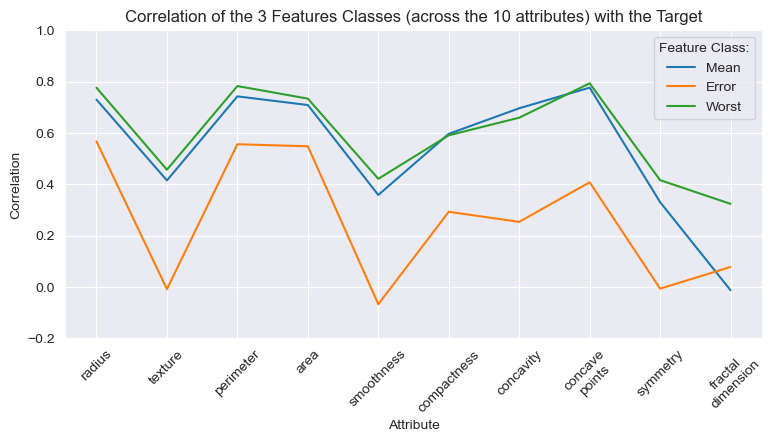

In [10]:
plt.figure(figsize=(9,4))
sns.lineplot(x=range(10), y=wbc.corr()['malignant'][0:10], label='Mean')
sns.lineplot(x=range(10), y=wbc.corr()['malignant'][10:20], label='Error')
sns.lineplot(x=range(10), y=wbc.corr()['malignant'][20:30], label='Worst')
plt.title('Correlation of the 3 Features Classes (across the 10 attributes) with the Target')
plt.legend(title='Feature Class:')
plt.ylim(-0.2, 1)
plt.ylabel('Correlation')
plt.xticks(ticks=range(10), labels=['radius', 'texture', 'perimeter', 'area', 'smoothness', 'compactness',
                                    'concavity', 'concave\npoints', 'symmetry', 'fractal\ndimension'], rotation=45)
plt.xlabel('Attribute');

From the above plot, it's clear that the feature classes **'Mean'** and **'Worst'** have almost the same correlation with the target across all 10 attributes, with 'fractal dimension' appearing to be the only attribute where this doesn't hold true. Assuming the corresponding attributes of these two feature classes are closely correlated with one another, it would make sense to drop one of these two feature classes from the dataset as there is little to be gained from using both.

Let's calculate the average correlation between the 10 corresponding attributes of these two feature classes.

In [11]:
a = 0
for i in range(10):
    a+= abs(round(wbc.corr()[wbc.columns[i]][i+20],2))

print(f"Average correlation between corresponding attributes in feature classes 'Mean' and 'Worst': {a/10}")

Average correlation between corresponding attributes in feature classes 'Mean' and 'Worst': 0.875


0.875 is very high average correlation. It thus makes sense to only use one of these two feature classes to predict the target. Let's create a new dataframe that doesn't contain the 'Mean' feature class - the 'Mean' feature class has a lower average correlation to the target than the 'Worst' feature class (see plot above).

In [12]:
wbc_1 = wbc.drop(wbc.columns[:10], axis=1).copy()
wbc_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   radius error             569 non-null    float64
 1   texture error            569 non-null    float64
 2   perimeter error          569 non-null    float64
 3   area error               569 non-null    float64
 4   smoothness error         569 non-null    float64
 5   compactness error        569 non-null    float64
 6   concavity error          569 non-null    float64
 7   concave points error     569 non-null    float64
 8   symmetry error           569 non-null    float64
 9   fractal dimension error  569 non-null    float64
 10  worst radius             569 non-null    float64
 11  worst texture            569 non-null    float64
 12  worst perimeter          569 non-null    float64
 13  worst area               569 non-null    float64
 14  worst smoothness         5

The new dataframe contains 20 features and the target - that's still a lot of features. Let's check for multicollinearity between the different features to identify additional features we can drop.

#### Multicollinearity

In [13]:
wbc_1.corr().head()

radius error  texture error  perimeter error  area error  \
radius error          1.000000       0.213247         0.972794    0.951830   
texture error         0.213247       1.000000         0.223171    0.111567   
perimeter error       0.972794       0.223171         1.000000    0.937655   
area error            0.951830       0.111567         0.937655    1.000000   
smoothness error      0.164514       0.397243         0.151075    0.075150   

                  smoothness error  compactness error  concavity error  \
radius error              0.164514           0.356065         0.332358   
texture error             0.397243           0.231700         0.194998   
perimeter error           0.151075           0.416322         0.362482   
area error                0.075150           0.284840         0.270895   
smoothness error          1.000000           0.336696         0.268685   

                  concave points error  symmetry error  \
radius error                  0.513346        0.240567   
texture error                 0.230283        0.411621   
perimeter error               0.556264        0.266487   
area error                    0.415730        0.134109   
smoothness error              0.328429        0.413506   

                  fractal dimension error  ...  worst texture  \
radius error                     0.227754  ...       0.194799   
texture error                    0.279723  ...       0.409003   
perimeter error                  0.244143  ...       0.200371   
area error                       0.127071  ...       0.196497   
smoothness error                 0.427374  ...      -0.074743   

                  worst perimeter  worst area  worst smoothness  \
radius error             0.719684    0.751548          0.141919   
texture error           -0.102242   -0.083195         -0.073658   
perimeter error          0.721031    0.730713          0.130054   
area error               0.761213    0.811408          0.125389   
smoothness error        -0.217304   -0.182195          0.314457   

                  worst compactness  worst concavity  worst concave points  \
radius error               0.287103         0.380585              0.531062   
texture error             -0.092439        -0.068956             -0.119638   
perimeter error            0.341919         0.418899              0.554897   
area error                 0.283257         0.385100              0.538166   
smoothness error          -0.055558        -0.058298             -0.102007   

                  worst symmetry  worst fractal dimension  malignant  
radius error            0.094543                 0.049559   0.567134  
texture error          -0.128215                -0.045655  -0.008303  
perimeter error         0.109930                 0.085433   0.556141  
area error              0.074126                 0.017539   0.548236  
smoothness error       -0.107342                 0.101480  -0.067016  

[5 rows x 21 columns]

By examining just the head of the above correlation table, we can already see that there exists a high level of correlation between many of the features in the dataset. Let's drop all but the features with the strongest correlation to the target that have with a correaltion >0.80 with another feature.

In [14]:
corr_malig = wbc_1.corr()['malignant'].sort_values(ascending=False)
correlation = wbc_1.drop('malignant', axis=1).corr()
drop_list = []

for name in list(corr_malig.index[1:]):
    if name in drop_list:
        pass
    else:
        drop_list.extend(list(correlation[name][(correlation[name] != 1) & (abs(correlation[name]) > 0.8)].index))
                         
drop_list = list(set(drop_list))
drop_list

['fractal dimension error',
 'worst area',
 'worst concavity',
 'area error',
 'worst compactness',
 'concavity error',
 'worst perimeter',
 'perimeter error']

In [15]:
wbc_2 = wbc_1.drop(drop_list, axis=1).copy()
wbc_2

radius error  texture error  smoothness error  compactness error  \
0          1.0950         0.9053          0.006399            0.04904   
1          0.5435         0.7339          0.005225            0.01308   
2          0.7456         0.7869          0.006150            0.04006   
3          0.4956         1.1560          0.009110            0.07458   
4          0.7572         0.7813          0.011490            0.02461   
..            ...            ...               ...                ...   
564        1.1760         1.2560          0.010300            0.02891   
565        0.7655         2.4630          0.005769            0.02423   
566        0.4564         1.0750          0.005903            0.03731   
567        0.7260         1.5950          0.006522            0.06158   
568        0.3857         1.4280          0.007189            0.00466   

     concave points error  symmetry error  worst radius  worst texture  \
0                 0.01587         0.03003        25.380          17.33   
1                 0.01340         0.01389        24.990          23.41   
2                 0.02058         0.02250        23.570          25.53   
3                 0.01867         0.05963        14.910          26.50   
4                 0.01885         0.01756        22.540          16.67   
..                    ...             ...           ...            ...   
564               0.02454         0.01114        25.450          26.40   
565               0.01678         0.01898        23.690          38.25   
566               0.01557         0.01318        18.980          34.12   
567               0.01664         0.02324        25.740          39.42   
568               0.00000         0.02676         9.456          30.37   

     worst smoothness  worst concave points  worst symmetry  \
0             0.16220                0.2654          0.4601   
1             0.12380                0.1860          0.2750   
2             0.14440                0.2430          0.3613   
3             0.20980                0.2575          0.6638   
4             0.13740                0.1625          0.2364   
..                ...                   ...             ...   
564           0.14100                0.2216          0.2060   
565           0.11660                0.1628          0.2572   
566           0.11390                0.1418          0.2218   
567           0.16500                0.2650          0.4087   
568           0.08996                0.0000          0.2871   

     worst fractal dimension  malignant  
0                    0.11890          1  
1                    0.08902          1  
2                    0.08758          1  
3                    0.17300          1  
4                    0.07678          1  
..                       ...        ...  
564                  0.07115          1  
565                  0.06637          1  
566                  0.07820          1  
567                  0.12400          1  
568                  0.07039          0  

[569 rows x 13 columns]

We now have a dataset that contains 12 features plus the target ('malignant' - column)! Let's go ahead and perform a pairplot on this dataset.

### Pairplot

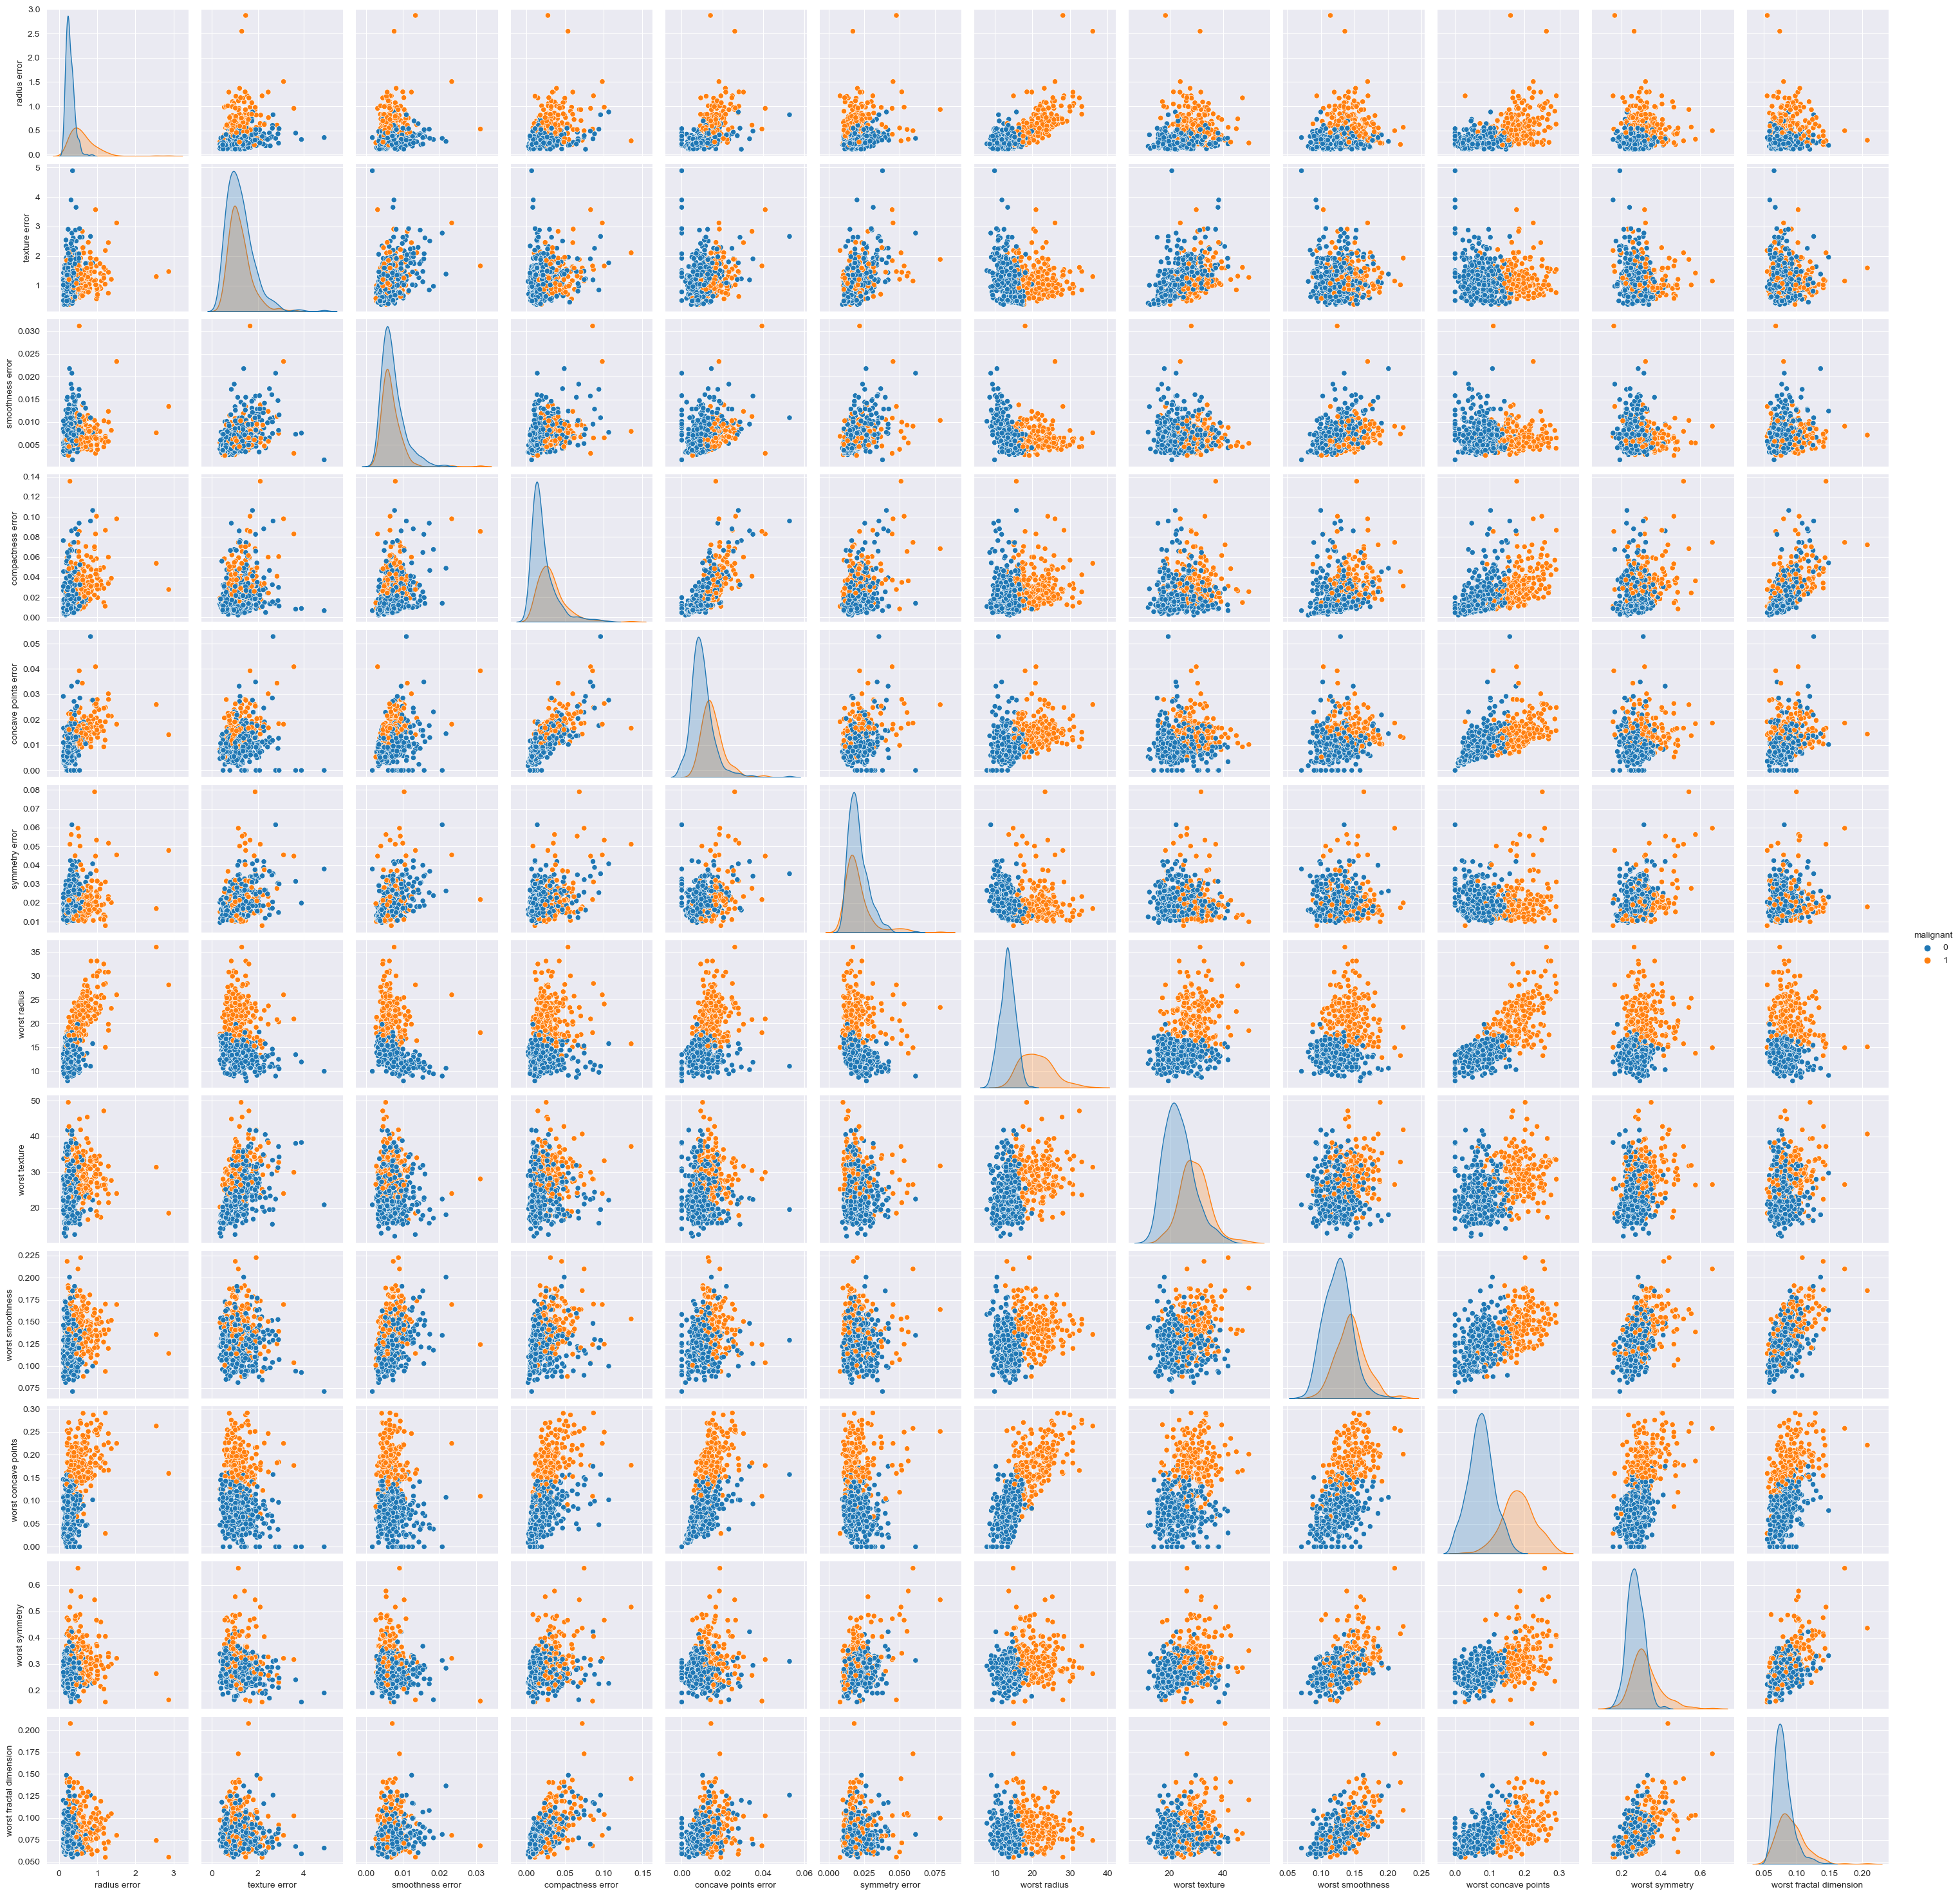

In [16]:
sns.pairplot(wbc_2, hue='malignant');

From the above pairplot, it's obvious that there are several features that will be good predictors for the target - eg. 'worst radius', 'worst concave points', etc. There also appears as if there might be several outliers within the dataset. However, given the limited number of observations (and my own lack of knowledge of the subject matter), I'm not going to remove any observations.

## Classification Models
**Methodology:**
1. Split the data in to train and test datasets.
2. Define scalers.
3. Define 9 classification models.
4. Evaluate the performance of the different models using cross-validation.
5. Refine the 3 best performing models.
6. Evaluate the performance of the 3 refined models and select the best performing one as the final model.

### Train, Test Split

In [17]:
X = wbc_2.drop(['malignant'], axis=1)
y = wbc_2['malignant']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 42, stratify= y)

#### Check Split

In [18]:
print("Percentage of Malignant Observations:")
print(f"Train dataset: {round(y_train.sum() * 100 / y_train.count(), 2)}%")
print(f"Test dataset: {round(y_test.sum() * 100 / y_test.count(), 2)}%")

Percentage of Malignant Observations:
Train dataset: 37.19%
Test dataset: 37.43%


The difference in the percentage of malignant observations in the train and test dataset is 0.24%. This is a negligibly small.

### Scalers

In [19]:
# StandardScaler
std_scaler = StandardScaler()
X_train_std = std_scaler.fit_transform(X_train)
X_test_std = std_scaler.transform(X_test)

# MinMaxScaler
minmax_scaler = MinMaxScaler()
X_train_min = minmax_scaler.fit_transform(X_train)
X_test_min = minmax_scaler.transform(X_test)

#### RepeatedStratifiedKFold
Given the limited number of observations in the training dataset, we will measure each classification model's performance using repeated stratified KFold cross validation. This will ensure that the final cross validation score obtained by each model is an accurate representation of that model's performance within the context of the WBC dataset.

In [20]:
rskf = RepeatedStratifiedKFold(n_splits= 5, n_repeats= 5, random_state= 42)
rskf.get_n_splits(X_train, y_train)

25

### Define the Models

In [21]:
# Create Classification Models
logreg = LogisticRegression()
kneigh = KNeighborsClassifier()
dtree = DecisionTreeClassifier()
rforest = RandomForestClassifier()
gboost = GradientBoostingClassifier()
hgboost = HistGradientBoostingClassifier()
extree = ExtraTreesClassifier()
aboost = AdaBoostClassifier()
xgboost = XGBClassifier()

model_list= [logreg, kneigh, dtree, rforest, gboost, hgboost, extree, aboost, xgboost]

# Dictionary of model types for ease of reference
model_dict = {0: "LogisticRegression", 1: "KNeighborsClassifier", 2: "DecisionTreeClassifier", 3: "RandomForestClassifier",
              4:"GradientBoostingClassifier", 5: "HistGradientBoostingClassifier", 6: "ExtraTreesClassifier",
              7:'AdaBoostClassifier', 8: "XGBClassifier"}

### Cross Validation of Models

In [22]:
cv_results_f1 = {}
for i, model in enumerate(model_list):
    if model == model_list[1]: # KNeighbor models generally perform better when using a MinMaxScaler
        f1_score = round((cross_val_score(model, X_train_min, y_train, scoring='f1', cv=rskf)).mean(), 6) 
    else:   
        f1_score = round((cross_val_score(model, X_train_std, y_train, scoring='f1', cv=rskf)).mean(), 6)
    cv_results_f1[model_dict[i]] = f1_score
    print(f"{i+1}. {model_dict[i]} f1-score: {f1_score}")

1. LogisticRegression f1-score: 0.947346
2. KNeighborsClassifier f1-score: 0.930459
3. DecisionTreeClassifier f1-score: 0.892159
4. RandomForestClassifier f1-score: 0.94026
5. GradientBoostingClassifier f1-score: 0.936545
6. HistGradientBoostingClassifier f1-score: 0.937889
7. ExtraTreesClassifier f1-score: 0.940521
8. AdaBoostClassifier f1-score: 0.933237
9. XGBClassifier f1-score: 0.943835


In [23]:
initial_models = pd.DataFrame(index=range(9), columns=['model'])
initial_models['model'] = model_dict
initial_models['f1_score'] = initial_models['model'].map(cv_results_f1)
initial_models.sort_values(by='f1_score', ascending=False).reset_index(drop=True)

model  f1_score
0              LogisticRegression  0.947346
1                   XGBClassifier  0.943835
2            ExtraTreesClassifier  0.940521
3          RandomForestClassifier  0.940260
4  HistGradientBoostingClassifier  0.937889
5      GradientBoostingClassifier  0.936545
6              AdaBoostClassifier  0.933237
7            KNeighborsClassifier  0.930459
8          DecisionTreeClassifier  0.892159

The 3 best performing classification models are:
1. **LogisticRegression**
2. **XGBClassifier**
3. **ExtraTreesClassifier**

Let's further refine these 3 models.

### Model Refinement

#### 1. LogisticRegression

In [24]:
params = {'C':[0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0],
          'max_iter':[50, 100],
          'fit_intercept':[True, False]}

logreg_grid = GridSearchCV(logreg, param_grid=params, verbose=1, scoring="f1", cv=rskf)
logreg_grid.fit(X_train_std, y_train)
logreg = logreg_grid.best_estimator_
logreg.fit(X_train_std, y_train)

print(f"\nRefined model: {logreg}")
print(f"\nOriginal model f1-score: {cv_results_f1['LogisticRegression']}")
print(f"Refined model f1-score: {round(logreg_grid.best_score_, 6)}")

Fitting 25 folds for each of 28 candidates, totalling 700 fits

Refined model: LogisticRegression(C=5.0, fit_intercept=False, max_iter=50)

Original model f1-score: 0.947346
Refined model f1-score: 0.955871


#### 2. XGBoostClassifier

In [25]:
params = {'n_estimators': [100, 200, 300],
          'learning_rate': [0.1, 0.25, 0.5, 1.0]}

xgb_grid = GridSearchCV(xgboost, param_grid=params, verbose=1, scoring="f1", cv=rskf)
xgb_grid.fit(X_train_std, y_train)
xgboost = xgb_grid.best_estimator_
xgboost.fit(X_train_std, y_train)

print(f"\nRefined model: {xgboost}")
print(f"\nOriginal model f1-score: {cv_results_f1['XGBClassifier']}")
print(f"Refined model f1-score: {round(xgb_grid.best_score_, 6)}")

Fitting 25 folds for each of 12 candidates, totalling 300 fits

Refined model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.25, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

Original model f1-score: 0.943835
Refined model f1-score: 0.947322


#### 3. ExtraTreesClassifier

In [26]:
params = {'n_estimators': [75, 100, 125],
          'min_samples_split':[2, 3, 4],
          'max_features':[3, 4, 5]}

ext_grid = GridSearchCV(extree, param_grid=params, verbose=1, scoring='f1', cv=rskf)
ext_grid.fit(X_train_std, y_train)
extree= ext_grid.best_estimator_
extree.fit(X_train_std, y_train)

print(f"\nRefined model: {extree}")
print(f"\nOriginal model f1-score: {cv_results_f1['ExtraTreesClassifier']}")
print(f"Refined model f1-score: {round(ext_grid.best_score_, 6)}")

Fitting 25 folds for each of 27 candidates, totalling 675 fits

Refined model: ExtraTreesClassifier(max_features=4, min_samples_split=3, n_estimators=125)

Original model f1-score: 0.940521
Refined model f1-score: 0.948846


### Model Evaluation
We will record the precision and recall scores for each of the 3 model across a range of different probabilities (1.0% - 99.0%) for both the train and test dataset. We will then plot the results so that we can determine which model performed the best, and at what probability.

**Note:** Given the limited number of observations in the dataset, both the train and test datasets will be used to evaluate the different model's performance.

In [27]:
log_results = {'train':{'rec':[], 'pre':[]}, 'test':{'rec':[], 'pre':[]}}
xgb_results = {'train':{'rec':[], 'pre':[]}, 'test':{'rec':[], 'pre':[]}}
ext_results = {'train':{'rec':[], 'pre':[]}, 'test':{'rec':[], 'pre':[]}}

#### 1. LogisticRegression

In [28]:
for prob in range(1,100):
    log_results['train']['rec'].append(recall_score(y_train, (logreg.predict_proba(X_train_std)[:,1] > prob/100) * 1))
    log_results['train']['pre'].append(precision_score(y_train, (logreg.predict_proba(X_train_std)[:,1] > prob/100) * 1))
    log_results['test']['rec'].append(recall_score(y_test, (logreg.predict_proba(X_test_std)[:,1] > prob/100) * 1))
    log_results['test']['pre'].append(precision_score(y_test, (logreg.predict_proba(X_test_std)[:,1] > prob/100) * 1))

#### 2. XGBoostClassifier

In [29]:
for prob in range(1,100):
    xgb_results['train']['rec'].append(recall_score(y_train, (xgboost.predict_proba(X_train_std)[:,1] > prob/100) * 1))
    xgb_results['train']['pre'].append(precision_score(y_train, (xgboost.predict_proba(X_train_std)[:,1] > prob/100) * 1))
    xgb_results['test']['rec'].append(recall_score(y_test, (xgboost.predict_proba(X_test_std)[:,1] > prob/100) * 1))
    xgb_results['test']['pre'].append(precision_score(y_test, (xgboost.predict_proba(X_test_std)[:,1] > prob/100) * 1))

#### 3. ExtraTreesClassifier

In [30]:
for prob in range(1,100):
    ext_results['train']['rec'].append(recall_score(y_train, (extree.predict_proba(X_train_std)[:,1] > prob/100) * 1))
    ext_results['train']['pre'].append(precision_score(y_train, (extree.predict_proba(X_train_std)[:,1] > prob/100) * 1))
    ext_results['test']['rec'].append(recall_score(y_test, (extree.predict_proba(X_test_std)[:,1] > prob/100) * 1))
    ext_results['test']['pre'].append(precision_score(y_test, (extree.predict_proba(X_test_std)[:,1] > prob/100) * 1))

#### Plot the Results

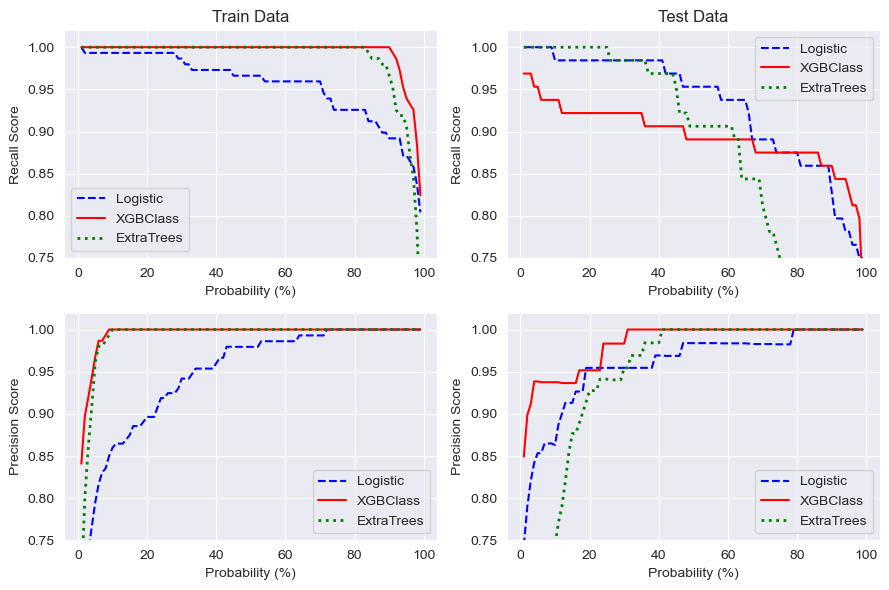

In [31]:
plt.figure(figsize=(9,6))

plt.subplot(2,2,1)
sns.lineplot(x=range(1,100), y= log_results['train']['rec'], color='blue', label='Logistic', ls='--')
sns.lineplot(x=range(1,100), y= xgb_results['train']['rec'], color='red', label='XGBClass')
sns.lineplot(x=range(1,100), y= ext_results['train']['rec'], color='green', label='ExtraTrees', ls=':', lw=2)
plt.title('Train Data')
plt.ylabel('Recall Score')

plt.subplot(2,2,2)
sns.lineplot(x=range(1,100), y= log_results['test']['rec'], color='blue', label='Logistic', ls='--')
sns.lineplot(x=range(1,100), y= xgb_results['test']['rec'], color='red', label='XGBClass')
sns.lineplot(x=range(1,100), y= ext_results['test']['rec'], color='green', label='ExtraTrees', ls=':', lw=2)
plt.title('Test Data')
plt.ylabel('Recall Score')

plt.subplot(2,2,3)
sns.lineplot(x=range(1,100), y= log_results['train']['pre'], color='blue', label='Logistic', ls='--')
sns.lineplot(x=range(1,100), y= xgb_results['train']['pre'], color='red', label='XGBClass')
sns.lineplot(x=range(1,100), y= ext_results['train']['pre'], color='green', label='ExtraTrees', ls=':', lw=2)
plt.ylabel('Precision Score')

plt.subplot(2,2,4)
sns.lineplot(x=range(1,100), y= log_results['test']['pre'], color='blue', label='Logistic', ls='--')
sns.lineplot(x=range(1,100), y= xgb_results['test']['pre'], color='red', label='XGBClass')
sns.lineplot(x=range(1,100), y= ext_results['test']['pre'], color='green', label='ExtraTrees', ls=':', lw=2)
plt.ylabel('Precision Score')

for i in range(1,5):
    plt.subplot(2,2,i)
    plt.xlabel('Probability (%)')
    plt.ylim(0.75,1.02)
plt.tight_layout();

#### Discussion
**Train Dataset:**

When it comes to classifying the observations within the train dataset, the LogisticRegression Model is easily the worst performing of the 3 refined models - it is outperfomed by both the XGBClassifier and ExtraTreesClassifier in both precision and recall across almost every probability. The XGBClassifier and ExtraTreesClassifier are equally matched across the vast majority of probabilities examined.

**Test Dataset:**

When it comes to classifying the observations within the test dataset, the 3 models are more equally matched. However, as recall is more important than precision (at least in the context of diagnosing a life threathening condition), the XGBClassifier's performance falls short of the other two models. As for the other two models, both are able to achieve a recall score of 1.00 at low probabilities. However, the ExtraTreesClassifier is able to simultaneously achieve a recall score of 1.00 and a precision score of +-0.94, whilst the LogisticRegression model is only able to simultaneously achieve a recall score of 1.00 and a precision score of +-0.87.

In light of the above, it's clear that the ExtraTreesClassifier is the best performing model. Let's print out the classification report and confusion matrix for this model at it's optimum probablity - would appear to be +-24.0 %.

In [32]:
prob = 0.24
print(f"TRAIN DATA:\n{classification_report(y_train, (extree.predict_proba(X_train_std)[:,1] > prob) * 1)}")
print(confusion_matrix(y_train, extree.predict_proba(X_train_std)[:,1] > prob) * 1)
print(f"\nTEST DATA:\n{classification_report(y_test, (extree.predict_proba(X_test_std)[:,1] > prob) * 1)}")
print(confusion_matrix(y_test, extree.predict_proba(X_test_std)[:,1] > prob) * 1)

TRAIN DATA:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       250
           1       1.00      1.00      1.00       148

    accuracy                           1.00       398
   macro avg       1.00      1.00      1.00       398
weighted avg       1.00      1.00      1.00       398

[[250   0]
 [  0 148]]

TEST DATA:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       107
           1       0.94      1.00      0.97        64

    accuracy                           0.98       171
   macro avg       0.97      0.98      0.98       171
weighted avg       0.98      0.98      0.98       171

[[103   4]
 [  0  64]]


Using a cutoff probability of 24%, the refined ExtraTreesClassifier model was able to accurately classify every observation within the train dataset. It was also able to correctly identify every malignant observation within the test dataset as being malignant, and only misidentified 4 out of 107 (+-4%) benign observations as being maliginant - this is an acceptably small amount!